In [1]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from fytok.Tokamak import Tokamak
from fytok.utils.load_scenario import load_scenario
from fytok.utils.plot_profiles import plot_profiles, sp_figure
import scipy.constants
from spdm.data.Expression import Variable
from spdm.data.File import File
from spdm.utils.logger import logger
import freegs


2023-06-17 16:53:36,899 INFO [spdm] : Set mapping path: /home/salmon/workspace/fytok/python/fytok/_mapping


In [2]:
scenario = load_scenario("/home/salmon/workspace/data/15MA inductive - burn")
tok = Tokamak("ITER",
              name=scenario["name"],
              description=scenario["description"],
              core_profiles={**scenario["core_profiles"],
                             #  "$default_value": {
                             #      "profiles_1d": {"grid": {
                             #          "rho_tor_norm": np.linspace(0, 1.0, 100),
                             #          "psi": np.linspace(0, 1.0, 100),
                             #          "psi_magnetic_axis": 0.0,
                             #          "psi_boundary": 1.0,
                             #      }}}
                             },
              equilibrium={**scenario["equilibrium"],
                           "code": {"name":  "freegs", "parameters": {"boundary": "free"}},
                           "$default_value": {"time_slice": {
                               "boundary": {"psi_norm": 0.99},
                               "coordinate_system": {"grid": {"dim1": 256, "dim2": 128}}
                           }}}
              )
display(tok)

2023-06-17 16:53:38,996 INFO [spdm] : Load scenario/profiles from /home/salmon/workspace/data/15MA inductive - burn/15MA Inductive at burn-ASTRA.xls
2023-06-17 16:53:39,070 INFO [spdm] : Load module spdm.plugins.data.PluginGEQdsk from /home/salmon/workspace/SpDB/python/spdm/plugins/data/PluginGEQdsk.py
2023-06-17 16:53:39,071 DEBUG [spdm] /home/salmon/workspace/SpDB/python/spdm/plugins/data/PluginGEQdsk.py:329:__init__: Open File URITuple(protocol='local', authority='', path=PosixPath('/home/salmon/workspace/data/15MA inductive - burn/Increased domain R-Z/Medium resolution - 129x257/g900003.00230_ITER_15MA_eqdsk16VVMR.txt'), query=None, fragment='', format='', schema='') mode=Mode.read
2023-06-17 16:53:39,097 INFO [spdm] : Load scenario/equilibrium from /home/salmon/workspace/data/15MA inductive - burn/Increased domain R-Z/Medium resolution - 129x257/g900003.00230_ITER_15MA_eqdsk16VVMR.txt
2023-06-17 16:53:39,110 INFO [spdm] : Load module spdm.plugins.data.PluginXML from /home/salmon/w

2023-06-17 16:53:43,604 INFO [spdm] : Update Equilibrium: EquilibriumFreeGS
2023-06-17 16:53:43,615 INFO [spdm] : Using free boundary
2023-06-17 16:53:43,628 INFO [spdm] : Setup machine description: wall={'name': 'ITER', 'index': 1, 'description': 'for equilibrium codes (single closed limiter and vessel);'}
2023-06-17 16:53:46,284 INFO [spdm] : Create Profile: Specified profile functions p'(psi), ff'(psi)
2023-06-17 16:53:46,286 DEBUG [spdm] /home/salmon/workspace/fytok/python/fytok/plugins/equilibrium/eq_analyze.py:110:__init__: Create MagneticCoordSystem.
2023-06-17 16:53:46,288 DEBUG [spdm] /home/salmon/workspace/fytok/python/fytok/plugins/equilibrium/eq_analyze.py:126:__init__: COCOS=5
2023-06-17 16:53:46,358 INFO [spdm] : Using fixed lcfs
2023-06-17 16:53:46,359 INFO [spdm] : Using xpoints: [(5.106664972154215, -3.4178882792990954, array(-1.07661824)), (4.4257274334903185, 4.789306332840519, array(-0.01293872))]
2023-06-17 16:53:46,360 INFO [spdm] : Solve G-S equation START


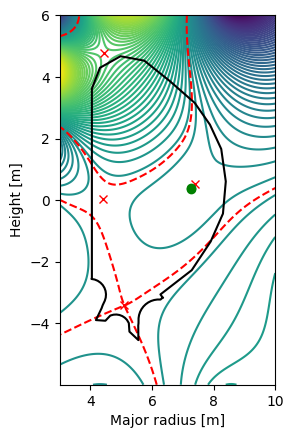

psi_relchange: 1.0510618666412055
bndry_relchange: 0.02
bndry_change: 10.0


psi_relchange: 0.00175349875272688
bndry_relchange: 1.0
bndry_change: 973.5386465786132


2023-06-17 16:53:48,130 INFO [spdm] : Solve G-S equation Done
2023-06-17 16:53:48,132 DEBUG [spdm] /home/salmon/workspace/fytok/python/fytok/modules/Equilibrium.py:33:update: Update Equlibrium at time=0.0
2023-06-17 16:53:48,134 INFO [spdm] : Update Equilibrium: EquilibriumFreeGS Done


In [3]:
eq = tok.equilibrium.update(
    core_profiles_1d=tok.core_profiles.profiles_1d.current,
    lcfs=True,
    xpoints=True,
    wall=tok.wall,
    pf_active=tok.pf_active,
    Ip=1.5e6, beta_p=0.6056,
    tolerance=1.0e-2,)


In [ ]:
fig, axis = plt.subplots()
tok.equilibrium.plot(axis)
tok.equilibrium._equilibrium.getMachine().plot(axis)

fig.show()

In [ ]:
tok

In [ ]:
j_tor=tok.equilibrium.time_slice.current.profiles_2d[0].j_tor.__array__()       
plt.imshow(j_tor, origin="lower", aspect="auto")

In [ ]:
tok.equilibrium

In [ ]:
j_tor = tok.equilibrium.time_slice[-1].profiles_2d[0].j_tor.__array__()
plt.plot(j_tor[60, :])


In [ ]:


psi_norm = tok.core_profiles.profiles_1d[-1].grid.psi_norm
R0 = tok.core_profiles.profiles_1d[-1].grid.r0
B0 = tok.core_profiles.profiles_1d[-1].grid.b0
pprime = tok.core_profiles.profiles_1d[-1].pprime.pullback(psi_norm)

ffprime = tok.core_profiles.profiles_1d[-1].ffprime.pullback(psi_norm)

profiles = freegs.jtor.ProfilesPprimeFfprime(pprime, ffprime, R0*B0)
